# Load and check data

In [1]:
import time
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

import nltk

from sklearn import metrics, model_selection, naive_bayes
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import xgboost as xgb

/home/guido/.conda/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load in the train and test datasets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

full_data = [train, test]

train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
# Explore the dataset 
print("Number of rows in train dataset {}".format(train.shape[0]))
print("Number of rows in test dataset {}".format(test.shape[0]))
print("No duplicates in train data") if train.shape[0] == train.text.unique().__len__() else print("Oops")
print("No duplicates in test data") if test.shape[0] == test.text.unique().__len__() else print("Oops")
print("Unique author is data {}".format(train.author.unique()))
print("Number of nulls in the train is {} and text is {}".format(train.isnull().sum().sum(), test.isnull().sum().sum()))

Number of rows in train dataset 19579
Number of rows in test dataset 8392
No duplicates in train data
No duplicates in test data
Unique author is data ['EAP' 'HPL' 'MWS']
Number of nulls in the train is 0 and text is 0


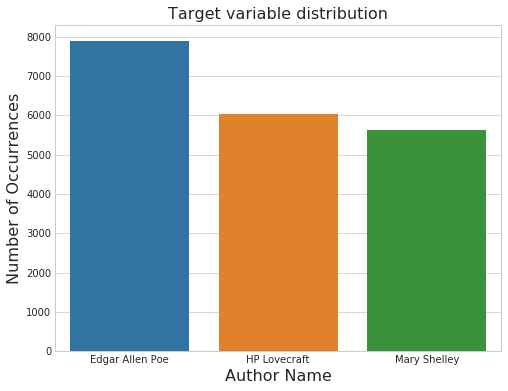

In [4]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
plt.figure(figsize=(8, 6))
plt.title('Target variable distribution', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Author Name', fontsize=16)
sns.barplot(x=train.author.map(z).unique(), y=train.author.value_counts().values)

# Wordclouds

## Visualise each author's work

In [5]:
from imageio import imread
from wordcloud import WordCloud, STOPWORDS

(-0.5, 399.5, 199.5, -0.5)

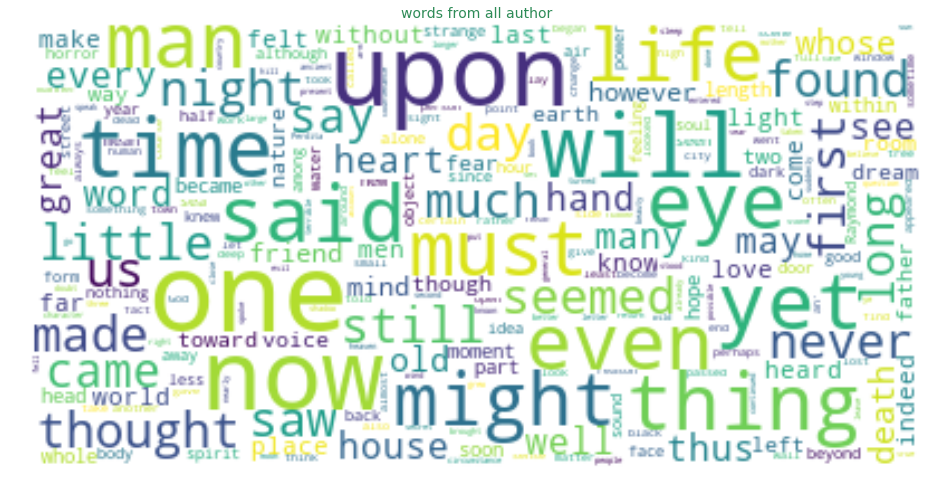

In [6]:
wc = WordCloud(
    background_color="white",
    max_words=5000,
    stopwords=STOPWORDS,
    max_font_size=50)
# generate word cloud
wc.generate(" ".join(train.text.values))

# show
plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from all author", fontsize=14, color='seagreen')
plt.axis("off")

In [7]:
img1 = imread("eap.png")
img2 = imread("mws.png")
img3 = imread("hpl.png")

In [8]:
eap = train[train.author == "EAP"]["text"].values
mws = train[train.author == "MWS"]["text"].values
hpl = train[train.author == "HPL"]["text"].values

(-0.5, 639.5, 390.5, -0.5)

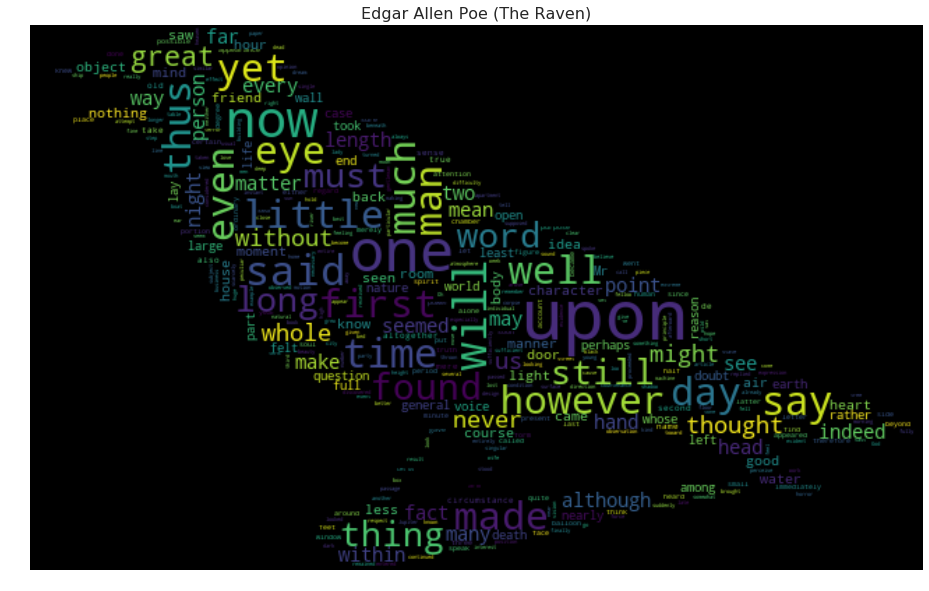

In [9]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img1,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(eap))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Edgar Allen Poe (The Raven)", fontsize=16)
plt.axis("off")

(-0.5, 639.5, 589.5, -0.5)

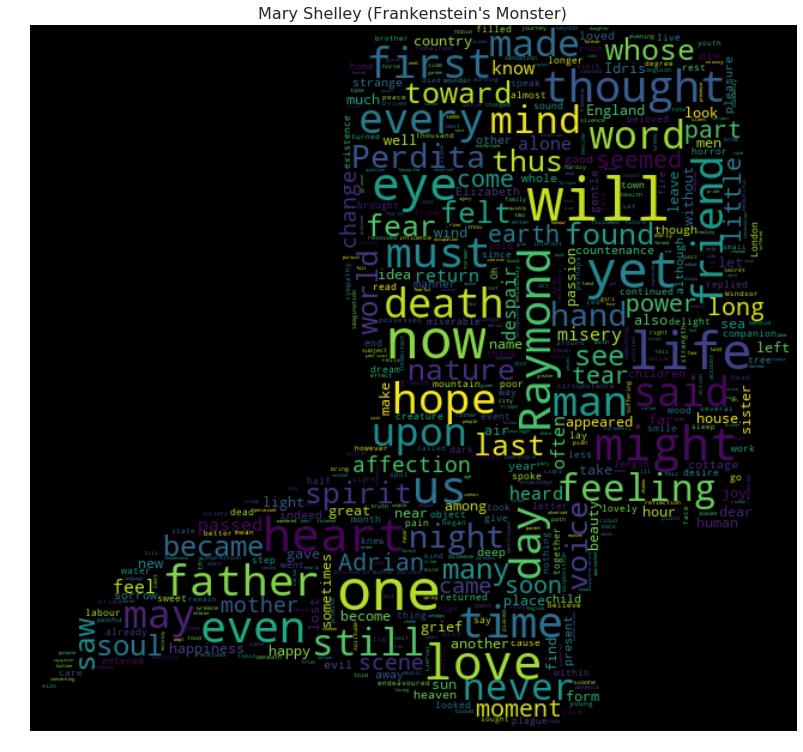

In [10]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img2,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(mws))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize=16)
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

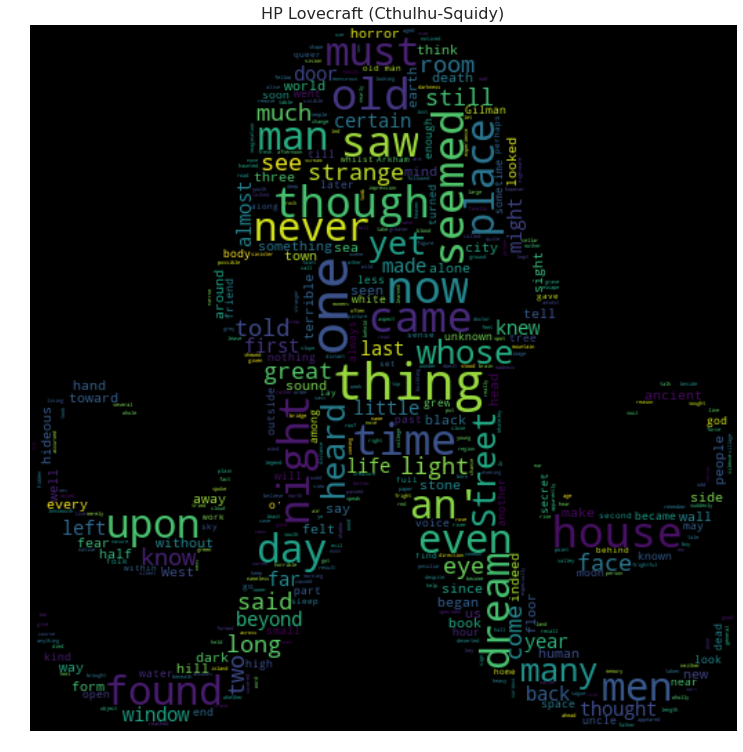

In [11]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img3,
    stopwords=STOPWORDS,
    max_font_size=40)
wc.generate(" ".join(hpl))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=16)
plt.axis('off')

# Natural Language Processing

## Tokenization

In [12]:
# Storing the first text element as a string
first_text = train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [13]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal

In [14]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [15]:
first_text_list_cleaned = [
    word for word in first_text_list if word.lower() not in stopwords
]
print(first_text_list_cleaned)
print("=" * 90)
print("Length of original list: {} words\n"
      "Length of list after stopwords removal: {} words".format(
          len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming and Lemmatization

In [16]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
The stemmed form of leaves is: leav


In [17]:
lemm =  nltk.stem.WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("ascertaining")))

The lemmatized form of leaves is: leaf
The lemmatized form of leaves is: ascertaining


## Vectorizing Raw Text

In [18]:
# Defining our sentence
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try CountVectorizer
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [19]:
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try  TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[ 0.63009934  0.44832087  0.          0.44832087  0.44832087]
 [ 0.          0.44832087  0.63009934  0.44832087  0.44832087]]


# Fuctions

## Confusion Matrix

In [20]:
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Multinomial Naive Bayes

In [21]:
def runMNB(x_train, y_train, x_val, x_test):
    model = naive_bayes.MultinomialNB()
    model.fit(x_train, y_train)
    pred_y_val = model.predict_proba(x_val)
    pred_y_test = model.predict_proba(x_test)
    return pred_y_val, pred_y_test, model

## XGBoost

In [22]:
xgb_param = {
    'min_child_weight': 1,
    'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 3,
    'subsample': 0.8,
    'lambda': 2.0,
    'nthread': -1,
    'silent': 1,
    'eval_metric': "mlogloss",
    'objective': 'multi:softprob',
    'num_class': 3
}


def runXGB(x_train, y_train, x_val, y_val, x_test):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, y_val)
    dtest = xgb.DMatrix(x_test)
    watchlist = [(dtrain, 'train'), (dval, 'val')]

    model = xgb.train(
        xgb_param,
        dtrain,
        2000,
        watchlist,
        early_stopping_rounds=50,
        maximize=False,
        verbose_eval=40)
    pred_y_val = model.predict(dval, ntree_limit=model.best_ntree_limit)
    pred_y_test = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    return pred_y_val, pred_y_test, model

# Feature Engineering

## --- Text based features ---

In [23]:
import string


def word_count(raw):
    return len(raw['text'].split())


def char_count(raw):
    return len(raw['text'])


def word_len_mean(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return np.mean([len(w) for w in text_list])


def unique_word_count(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len(list(set(text_list)))


def stopwords_count(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    return len([w for w in text_list if w in stopwords])


def punctuations_count(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    return len([w for w in text_list if w in string.punctuation])


def word_upper_count(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.isupper()])


def word_title_count(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.istitle()])


def unique_word_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    unique_word_count = len(list(set(text_list)))
    word_count = len(text_list)
    return unique_word_count / word_count


def stopwords_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    stopwords_count = len([w for w in text_list if w in stopwords])
    word_count = len(text_list)
    return stopwords_count / word_count


def punctuations_fraction(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    punctuation_count = len([w for w in text_list if w in string.punctuation])
    char_count = len(text)
    return punctuation_count / char_count


def word_upper_fraction(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    word_upper_count = len([w for w in text_list if w.isupper()])
    word_count = len(text_list)
    return word_upper_count / word_count


def word_title_fraction(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    word_title_count = len([w for w in text_list if w.istitle()])
    word_count = len(text_list)
    return word_title_count / word_count


def noun_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    noun_count = len(
        [w for w in pos_list if w[1] in ('NN', 'NNP', 'NNPS', 'NNS')])
    word_count = len(text_list)
    return noun_count / word_count


def adj_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    adj_count = len([w for w in pos_list if w[1] in ('JJ', 'JJR', 'JJS')])
    word_count = len(text_list)
    return adj_count / word_count


def verbs_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    verbs_count = len([
        w for w in pos_list
        if w[1] in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')
    ])
    word_count = len(text_list)
    return verbs_count / word_count

In [24]:
for dataset in full_data:
    dataset['word_count'] = dataset.apply(lambda raw: word_count(raw), axis=1)
    dataset['char_count'] = dataset.apply(lambda raw: char_count(raw), axis=1)
    dataset['word_len_mean'] = dataset.apply(lambda raw: word_len_mean(raw), axis=1)
    
    dataset['unique_word_count'] = dataset.apply(lambda raw: unique_word_count(raw), axis=1)
    dataset['stopwords_count'] = dataset.apply(lambda raw: stopwords_count(raw), axis=1)
    dataset['punctuations_count'] = dataset.apply(lambda raw: punctuations_count(raw), axis=1)
    dataset['word_upper_count'] = dataset.apply(lambda raw: word_upper_count(raw), axis=1)
    dataset['word_title_count'] = dataset.apply(lambda raw: word_title_count(raw), axis=1)
    
    dataset['unique_word_fraction'] = dataset.apply(lambda raw: unique_word_fraction(raw), axis=1)
    dataset['stopwords_fraction'] = dataset.apply(lambda raw: stopwords_fraction(raw), axis=1)
    dataset['punctuations_fraction'] = dataset.apply(lambda raw: punctuations_fraction(raw), axis=1)
    dataset['word_upper_fraction'] = dataset.apply(lambda raw: word_upper_fraction(raw), axis=1)
    dataset['word_title_fraction'] = dataset.apply(lambda raw: word_title_fraction(raw), axis=1)
    
    dataset['noun_fraction'] = dataset.apply(lambda raw: noun_fraction(raw), axis=1)
    dataset['adj_fraction'] = dataset.apply(lambda raw: adj_fraction(raw), axis=1)
    dataset['verbs_fraction'] = dataset.apply(lambda raw: verbs_fraction(raw), axis=1)

In [25]:
# Min-max normalization (specified columns)
#select_elements = ['word_count', 'char_count', 'word_len_mean', 'unique_word_count', 'stopwords_count', 'punctuations_count', 'word_upper_count', 'word_title_count']
#train.loc[:, select_elements] =  (train.loc[:, select_elements] - train.loc[:, select_elements].min()) / (train.loc[:, select_elements].max() - train.loc[:, select_elements].min())
#train.head()

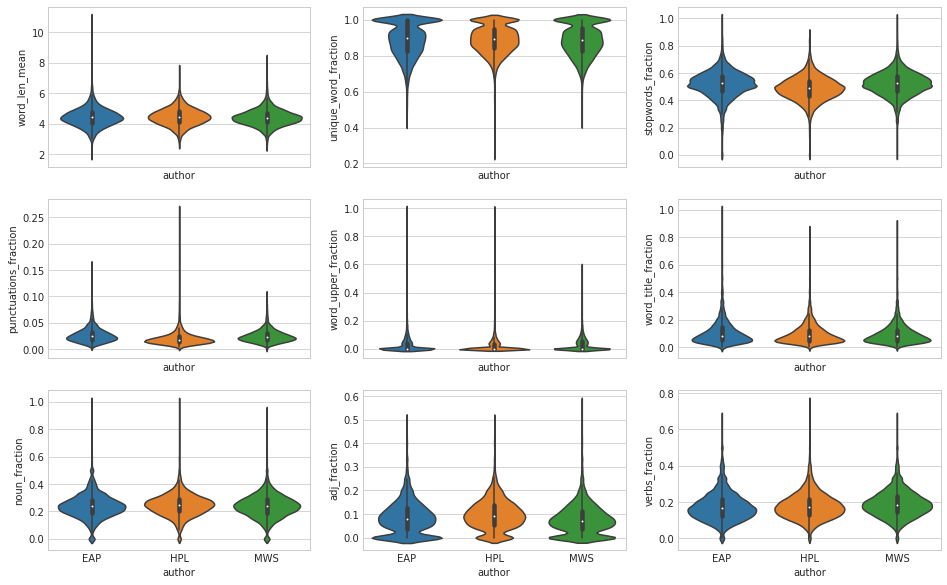

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=(16, 10))
sns.violinplot(x='author', y='word_len_mean', data=train, ax=ax[0, 0])
sns.violinplot(x='author', y='unique_word_fraction', data=train, ax=ax[0, 1])
sns.violinplot(x='author', y='stopwords_fraction', data=train, ax=ax[0, 2])

sns.violinplot(x='author', y='punctuations_fraction', data=train, ax=ax[1, 0])
sns.violinplot(x='author', y='word_upper_fraction', data=train, ax=ax[1, 1])
sns.violinplot(x='author', y='word_title_fraction', data=train, ax=ax[1, 2])

sns.violinplot(x='author', y='noun_fraction', data=train, ax=ax[2, 0])
sns.violinplot(x='author', y='adj_fraction', data=train, ax=ax[2, 1])
sns.violinplot(x='author', y='verbs_fraction', data=train, ax=ax[2, 2])

## XGBoost model using Text based features

In [27]:
# Prepare the data for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train['author'].map(author_mapping_dict)
id_train = train['id'].values
id_test = test['id'].values

drop_elements = ['id', 'text']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 16) (8392, 16)


,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,punctuations_fraction,word_upper_fraction,word_title_fraction,noun_fraction,adj_fraction,verbs_fraction
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,0.030303,0.04878,0.073171,0.292683,0.048780,0.146341
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,0.014085,0.00000,0.071429,0.142857,0.071429,0.142857
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,0.025000,0.00000,0.027778,0.277778,0.138889,0.111111
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,0.019417,0.00000,0.117647,0.294118,0.176471,0.147059
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,0.022989,0.00000,0.074074,0.222222,0.037037,0.222222


In [28]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

[0]	train-mlogloss:1.08762	val-mlogloss:1.08907
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.960029	val-mlogloss:0.984945
[80]	train-mlogloss:0.929692	val-mlogloss:0.967477
[120]	train-mlogloss:0.911581	val-mlogloss:0.959577
[160]	train-mlogloss:0.898984	val-mlogloss:0.956989
[200]	train-mlogloss:0.888438	val-mlogloss:0.955285
[240]	train-mlogloss:0.878812	val-mlogloss:0.954415
[280]	train-mlogloss:0.870162	val-mlogloss:0.954227
Stopping. Best iteration:
[259]	train-mlogloss:0.874821	val-mlogloss:0.953757

[0]	train-mlogloss:1.08797	val-mlogloss:1.08824
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.963335	val-mlogloss:0.974579
[80]	train-mlogloss:0.93324	val-mlogloss:0.953972
[120]	train-mlogloss:0.915465	val-mlogloss:0.94666
[160]	train-m

In [29]:
# add the predictions as new features
train["xgb_based_eap"] = pred_train[:, 0]
train["xgb_based_hpl"] = pred_train[:, 1]
train["xgb_based_mws"] = pred_train[:, 2]
test["xgb_based_eap"] = pred_full_test[:, 0]
test["xgb_based_hpl"] = pred_full_test[:, 1]
test["xgb_based_mws"] = pred_full_test[:, 2]

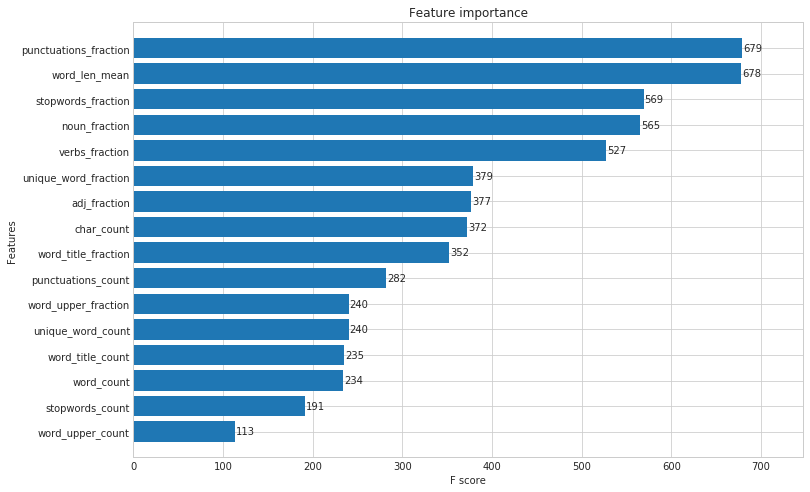

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

## Naive Bayes model using Text based features

In [31]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

Mean cv score: 1.039853560846631


In [32]:
# add the predictions as new features
train["nb_based_eap"] = pred_train[:, 0]
train["nb_based_hpl"] = pred_train[:, 1]
train["nb_based_mws"] = pred_train[:, 2]
test["nb_based_eap"] = pred_full_test[:, 0]
test["nb_based_hpl"] = pred_full_test[:, 1]
test["nb_based_mws"] = pred_full_test[:, 2]

Confusion matrix, without normalization
[[1208  187  200]
 [ 595  414   89]
 [ 858  147  217]]


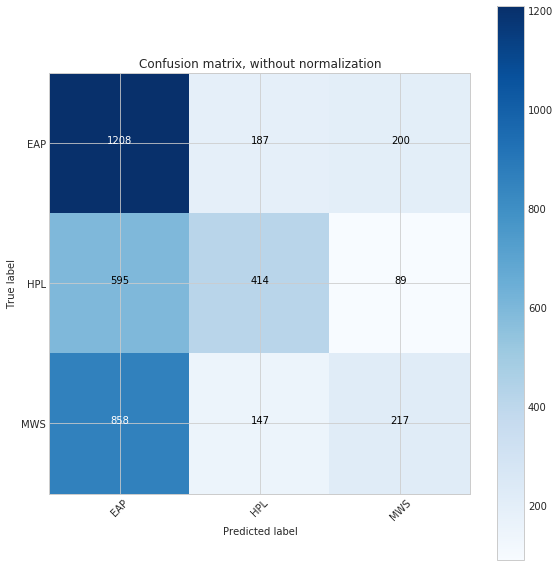

In [33]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## --- word Count and TFIDF features ---

In [34]:
lemm = nltk.stem.WordNetLemmatizer()


class LemmCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))


class LemmTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmTfidfVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [35]:
# word vectorizer
tf_vectorizer = LemmCountVectorizer(stop_words='english', ngram_range=(1,3))
tf_train = tf_vectorizer.fit_transform(train['text'].values.tolist())
tf_test = tf_vectorizer.transform(test['text'].values.tolist())

tfidf_vectorizer = LemmTfidfVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf_train = tfidf_vectorizer.fit_transform(train['text'].values.tolist())
tfidf_test = tfidf_vectorizer.transform(test['text'].values.tolist())

## Naive Bayes model using word Count features

In [36]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tf_train):
    x_dev, x_val = tf_train[idx_dev], tf_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tf_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 0.4581034305450692


In [37]:
# add the predictions as new features
train["nb_word_count_eap"] = pred_train[:, 0]
train["nb_word_count_hpl"] = pred_train[:, 1]
train["nb_word_count_mws"] = pred_train[:, 2]
test["nb_word_count_eap"] = pred_full_test[:, 0]
test["nb_word_count_hpl"] = pred_full_test[:, 1]
test["nb_word_count_mws"] = pred_full_test[:, 2]

Confusion matrix, without normalization
[[1308  110  177]
 [ 111  899   88]
 [ 121   50 1051]]


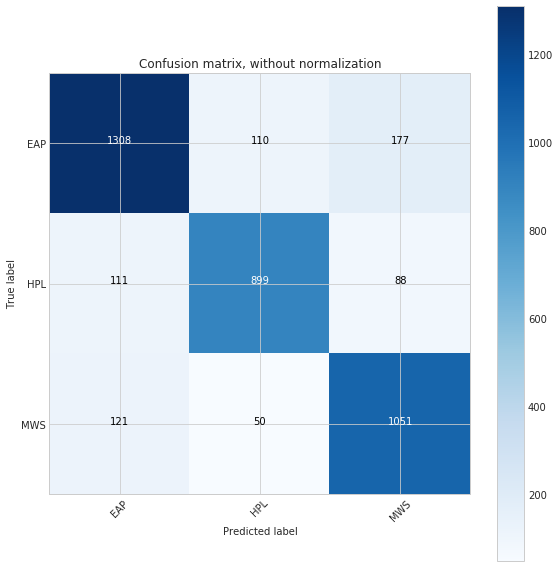

In [38]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## Naive Bayes model using word TFIDF features

In [39]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tfidf_train):
    x_dev, x_val = tfidf_train[idx_dev], tfidf_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tfidf_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 0.8335510961069861


In [40]:
# add the predictions as new features
train["nb_word_tfidf_eap"] = pred_train[:, 0]
train["nb_word_tfidf_hpl"] = pred_train[:, 1]
train["nb_word_tfidf_mws"] = pred_train[:, 2]
test["nb_word_tfidf_eap"] = pred_full_test[:, 0]
test["nb_word_tfidf_hpl"] = pred_full_test[:, 1]
test["nb_word_tfidf_mws"] = pred_full_test[:, 2]

Confusion matrix, without normalization
[[1532   16   47]
 [ 522  530   46]
 [ 453   11  758]]


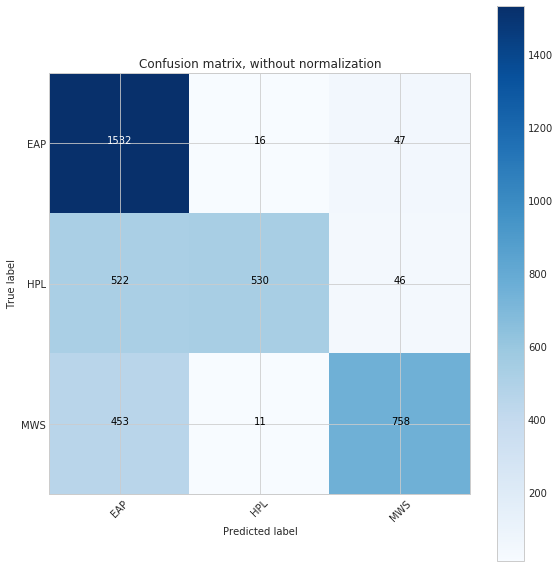

In [41]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## SVD on word TFIDF features

In [42]:
start = time.time()

n_comp = 300
svd = TruncatedSVD(n_components=n_comp, algorithm='arpack', random_state=2017)

svd_train = svd.fit_transform(tfidf_train)
svd_test = svd.transform(tfidf_test)
svd_train_df = pd.DataFrame(svd_train)
svd_test_df = pd.DataFrame(svd_test)

svd_train_df.columns = ['svd_word_' + str(i) for i in range(n_comp)]
svd_test_df.columns = ['svd_word_' + str(i) for i in range(n_comp)]
train = pd.concat([train, svd_train_df], axis=1)
test = pd.concat([test, svd_test_df], axis=1)

end = time.time()
print("Time taken in tf-idf is {}.".format(end - start))

Time taken in tf-idf is 34.24274253845215.


In [43]:
# Try to adjust the parameters of the TruncatedSVD n_components
#n_splits = 5
#kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
#cv_scores = []
#pred_full_test = 0
#pred_train = np.zeros([train.shape[0], 3])
#
#for idx_dev, idx_val in kf.split(svd_train):
#    x_dev, x_val = svd_train[idx_dev], svd_train[idx_val]
#    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
#    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, svd_test)
#    pred_full_test = pred_full_test + pred_y_test
#    pred_train[idx_val, :] = pred_y_val
#    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
#    break
#pred_full_test = pred_full_test / float(n_splits)
#print("Mean cv score : {}".format(np.mean(cv_scores)))

## --- char Count and TFIDF features ---

In [44]:
# char vectorizer
tfc_vectorizer = CountVectorizer(ngram_range=(1, 7), analyzer='char')
tfc_train = tfc_vectorizer.fit_transform(train['text'].values.tolist())
tfc_test = tfc_vectorizer.transform(test['text'].values.tolist())

tfidfc_vectorizer = TfidfVectorizer(ngram_range=(1, 7), analyzer='char')
tfidfc_train = tfidfc_vectorizer.fit_transform(train['text'].values.tolist())
tfidfc_test = tfidfc_vectorizer.transform(test['text'].values.tolist())

## Naive Bayes model using char Count features

In [45]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tfc_train):
    x_dev, x_val = tfc_train[idx_dev], tfc_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tfc_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 3.725182058538286


In [46]:
# add the predictions as new features
train["nb_char_count_eap"] = pred_train[:, 0]
train["nb_char_count_hpl"] = pred_train[:, 1]
train["nb_char_count_mws"] = pred_train[:, 2]
test["nb_char_count_eap"] = pred_full_test[:, 0]
test["nb_char_count_hpl"] = pred_full_test[:, 1]
test["nb_char_count_mws"] = pred_full_test[:, 2]

Confusion matrix, without normalization
[[1348   97  150]
 [ 141  887   70]
 [ 114   57 1051]]


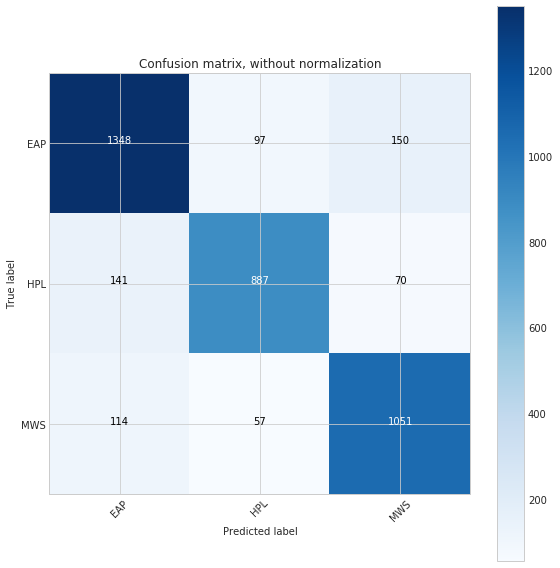

In [47]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## Naive Bayes model using char TFIDF features

In [48]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tfidfc_train):
    x_dev, x_val = tfidfc_train[idx_dev], tfidfc_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tfidfc_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 0.8924656818342923


In [49]:
# add the predictions as new features
train["nb_char_tfidf_eap"] = pred_train[:, 0]
train["nb_char_tfidf_hpl"] = pred_train[:, 1]
train["nb_char_tfidf_mws"] = pred_train[:, 2]
test["nb_char_tfidf_eap"] = pred_full_test[:, 0]
test["nb_char_tfidf_hpl"] = pred_full_test[:, 1]
test["nb_char_tfidf_mws"] = pred_full_test[:, 2]

Confusion matrix, without normalization
[[1578    2   15]
 [ 850  233   15]
 [ 798    4  420]]


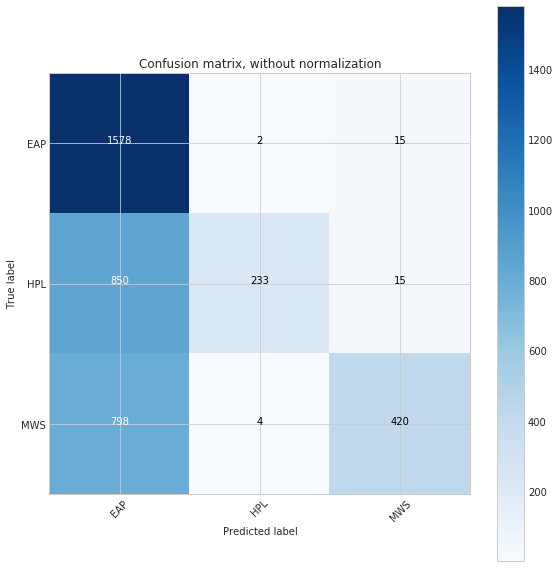

In [50]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## SVD on char TFIDF features

In [51]:
start = time.time()

n_comp = 200
svd = TruncatedSVD(n_components=n_comp, algorithm='arpack', random_state=2017)

svd_train = svd.fit_transform(tfidfc_train)
svd_test = svd.transform(tfidfc_test)
svd_train_df = pd.DataFrame(svd_train)
svd_test_df = pd.DataFrame(svd_test)

svd_train_df.columns = ['svd_char_' + str(i) for i in range(n_comp)]
svd_test_df.columns = ['svd_char_' + str(i) for i in range(n_comp)]
train = pd.concat([train, svd_train_df], axis=1)
test = pd.concat([test, svd_test_df], axis=1)

end = time.time()
print("Time taken in tf-idf is {}.".format(end - start))

Time taken in tf-idf is 127.00950050354004.


In [52]:
# Try to adjust the parameters of the TruncatedSVD n_components
#n_splits = 5
#kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
#cv_scores = []
#pred_full_test = 0
#pred_train = np.zeros([train.shape[0], 3])
#
#for idx_dev, idx_val in kf.split(svd_train):
#    x_dev, x_val = svd_train[idx_dev], svd_train[idx_val]
#    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
#    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, svd_test)
#    pred_full_test = pred_full_test + pred_y_test
#    pred_train[idx_val, :] = pred_y_val
#    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
#    break
#pred_full_test = pred_full_test / float(n_splits)
#print("Mean cv score : {}".format(np.mean(cv_scores)))

## --- Markov event based features ---

In [53]:
class Dictogram(dict):
    def __init__(self, iterable=None):
        """Initialize this histogram as a new dict; update with given items"""
        super(Dictogram, self).__init__()
        self.types = 0  # the number of distinct item types in this histogram
        self.tokens = 0  # the total count of all item tokens in this histogram
        if iterable:
            self.update(iterable)

    def update(self, iterable):
        """Update this histogram with the items in the given iterable"""
        for item in iterable:
            if item in self:
                self[item] += 1
                self.tokens += 1
            else:
                self[item] = 1
                self.types += 1
                self.tokens += 1

    def count(self, item):
        """Return the count of the given item in this histogram, or 0"""
        if item in self:
            return self[item]
        return 0

    def return_random_word(self):
        # Another way:  Should test: random.choice(histogram.keys())
        random_key = random.sample(self, 1)
        return random_key[0]

    def return_weighted_random_word(self):
        # Step 1: Generate random number between 0 and total count - 1
        random_int = random.randint(0, self.tokens - 1)
        index = 0
        list_of_keys = self.keys()
        # print 'the random index is:', random_int
        for i in range(0, self.types):
            index += self[list_of_keys[i]]
            # print index
            if (index > random_int):
                # print list_of_keys[i]
                return list_of_keys[i]

In [54]:
# markov chain based features, order words memory
def make_higher_order_markov_model(data, order):
    markov_model = dict()

    for char_list in data:
        for i in range(len(char_list) - order):
            # Create the window
            window = tuple(char_list[i:i + order])
            # Add to the dictionary
            if window in markov_model:
                # We have to just append to the existing Dictogram
                markov_model[window].update([char_list[i + order]])
            else:
                markov_model[window] = Dictogram([char_list[i + order]])
    return markov_model

In [55]:
def text_to_char_list(raw):
    text = raw['text'].lower()
    char_list = [c for c in text]

    return char_list

In [62]:
def make_tuples(char_list, order):
    """function to make tuples of order size given a char_list and order"""
    list_of_tuple = []
    chars = []
    for i in range(len(char_list) - order):
        window = tuple(char_list[i:i + order])
        list_of_tuple.append(window)
        chars.append(char_list[i + order])
    return (list_of_tuple, chars)


def sent_to_prob(raw, author, order):
    """function to get the markov model to give prob of a author given a char_list """
    char_list = raw['splited_char_list']
    list_of_tuples, chars = make_tuples(char_list, order)

    p = 0

    # convert to log so we can sum probabilities instead of multiply
    if author == 'eap':
        for i in range(len(chars)):
            try:
                p_char = eap_MM[list_of_tuples[i]][chars[i]]
                p_chars = sum([x for x in eap_MM[list_of_tuples[i]].values()])
            except:
                p_char = 1
                p_chars = 1
            p += np.log(p_char / p_chars)
    elif author == 'hpl':
        for i in range(len(chars)):
            try:
                p_char = hpl_MM[list_of_tuples[i]][chars[i]]
                p_chars = sum([x for x in hpl_MM[list_of_tuples[i]].values()])
            except:
                p_char = 1
                p_chars = 1
            p += np.log(p_char / p_chars)
    elif author == 'mws':
        for i in range(len(chars)):
            try:
                p_char = mws_MM[list_of_tuples[i]][chars[i]]
                p_chars = sum([x for x in mws_MM[list_of_tuples[i]].values()])
            except:
                p_char = 1
                p_chars = 1
            p += np.log(p_char / p_chars)

    return p

In [64]:
full_data = [train, test]
order = 4

for dataset in full_data:
    dataset['splited_char_list'] = dataset.apply(lambda raw: text_to_char_list(raw), axis=1)
    
raw_eap = train[train.author == 'EAP']['splited_char_list'].values
raw_hpl = train[train.author == 'HPL']['splited_char_list'].values
raw_mws = train[train.author == 'MWS']['splited_char_list'].values

eap_MM = make_higher_order_markov_model(raw_eap, order)
hpl_MM = make_higher_order_markov_model(raw_hpl, order)
mws_MM = make_higher_order_markov_model(raw_mws, order)

In [58]:
print(eap_MM[('n', 'o', 'm', 'e')])
print(sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))
print(eap_MM[('n', 'o', 'm', 'e')]['r'])
print(eap_MM[('n', 'o', 'm', 'e')]['r'] / sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))

{'r': 12, 'n': 21, 't': 1, 's': 1}
35
12
0.34285714285714286


In [ ]:
for dataset in full_data:
    dataset['EAP_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'eap', order), axis=1)
    dataset['HPL_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'hpl', order), axis=1)
    dataset['MWS_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'mws', order), axis=1)
    
    del dataset['splited_char_list']

train[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]].head()

{'r': 12, 'n': 21, 't': 1, 's': 1}
35
12
0.34285714285714286


## lda TODO

In [20]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = ("\nTopic #{}: ").format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [21]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)

lda.fit(tf_train)


n_top_words = 20
print("Topics in LDA model: ")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)


first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]

first_topic.shape


first_topic_words = [
    tfidf_feature_names[i] for i in first_topic.argsort()[:-50 - 1:-1]
]
second_topic_words = [
    tfidf_feature_names[i] for i in second_topic.argsort()[:-50 - 1:-1]
]
third_topic_words = [
    tfidf_feature_names[i] for i in third_topic.argsort()[:-50 - 1:-1]
]

## --- Sentiment Analysis based features ---

# Ensembling & Stacking models

In [189]:
# Prepare the data for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train['author'].map(author_mapping_dict)
id_train = train['id'].values
id_test = test['id'].values

drop_elements = ['id', 'text']
#drop_elements = ['id', 'text', 'EAP_markov_3', 'HPL_markov_3', 'MWS_markov_3']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 111) (8392, 111)


,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,...,svd_char_33,svd_char_34,svd_char_35,svd_char_36,svd_char_37,svd_char_38,svd_char_39,EAP_markov_3,HPL_markov_3,MWS_markov_3
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,...,0.020853,0.050947,-0.018300,0.005155,0.009575,0.029565,0.030512,-329.997505,-339.219483,-353.543150
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,...,-0.021186,0.022989,-0.056868,-0.016957,0.051687,0.015962,-0.006381,-99.452053,-97.257485,-98.828394
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,...,-0.001981,-0.001908,0.013497,-0.029306,-0.018776,0.010740,0.029868,-303.931557,-302.572178,-320.248967
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,...,-0.007202,0.005220,-0.012104,-0.016946,0.018283,-0.006900,-0.000147,-368.216615,-355.037287,-323.700297
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,...,0.025903,-0.027620,-0.016221,-0.007860,0.003379,-0.021110,-0.018357,-267.337294,-270.323647,-271.203594


In [209]:
tmp_x_train = x_train[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
x_train_t = x_train.drop(['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)], axis=1)

tmp_x_test = x_test[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
x_test_t = x_test.drop(['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)], axis=1)

# word_count, char_count, word_len_mean, unique_word_count, stopwords_count, punctuations_count, word_upper_count, word_title_count

# Min-max normalization (column)
#x_train_t = (x_train_t - x_train_t.min()) / (x_train_t.max() - x_train_t.min())
#x_test_t = (x_test_t - x_test_t.min()) / (x_test_t.max() - x_test_t.min())

# Min-max normalization (row)
tmp_x_train = tmp_x_train.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
tmp_x_test = tmp_x_test.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

#train = pd.concat([train, svd_train_df], axis=1) ----------
x_train_t = x_train_t.join(tmp_x_train)
x_test_t = x_test_t.join(tmp_x_test)

x_train_t.head()

,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,...,svd_char_33,svd_char_34,svd_char_35,svd_char_36,svd_char_37,svd_char_38,svd_char_39,EAP_markov_3,HPL_markov_3,MWS_markov_3
0,0.045402,0.045239,0.285247,0.083130,0.045977,0.113208,0.074074,0.065217,0.804878,0.487805,...,0.575250,0.685865,0.390262,0.468010,0.479547,0.537003,0.595532,1.000000,0.608336,0.000000
1,0.013970,0.010771,0.239547,0.031785,0.018391,0.000000,0.000000,0.021739,1.000000,0.571429,...,0.383162,0.575026,0.216188,0.380846,0.672495,0.481292,0.441771,0.000000,1.000000,0.284183
2,0.039581,0.038561,0.280488,0.075795,0.039080,0.075472,0.000000,0.021739,0.851852,0.472222,...,0.470917,0.476322,0.533780,0.332163,0.349650,0.459908,0.592848,0.923098,1.000000,0.000000
3,0.037253,0.039854,0.338235,0.073350,0.029885,0.056604,0.000000,0.086957,0.882353,0.382353,...,0.447058,0.504579,0.418229,0.380887,0.519446,0.387666,0.467754,0.000000,0.296056,1.000000
4,0.029104,0.032960,0.378049,0.058680,0.025287,0.056604,0.000000,0.043478,0.901235,0.407407,...,0.598328,0.374387,0.399647,0.416705,0.451159,0.329471,0.391860,1.000000,0.227594,0.000000


## Kfold method

In [211]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train_t):
    x_dev, x_val = x_train_t.loc[idx_dev], x_train_t.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, x_test_t)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
    break
#pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

[0]	train-mlogloss:1.0009	val-mlogloss:1.00082
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.339929	val-mlogloss:0.352241
[80]	train-mlogloss:0.292632	val-mlogloss:0.324533
[120]	train-mlogloss:0.26568	val-mlogloss:0.314763
[160]	train-mlogloss:0.24646	val-mlogloss:0.309763
[200]	train-mlogloss:0.229259	val-mlogloss:0.306065
[240]	train-mlogloss:0.214195	val-mlogloss:0.302797
[280]	train-mlogloss:0.200828	val-mlogloss:0.301573
[320]	train-mlogloss:0.188581	val-mlogloss:0.300365
[360]	train-mlogloss:0.177575	val-mlogloss:0.300147
Stopping. Best iteration:
[345]	train-mlogloss:0.181604	val-mlogloss:0.299727

Mean cv score: 0.2997266198046355


In [212]:
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171128-03.csv", index=False)

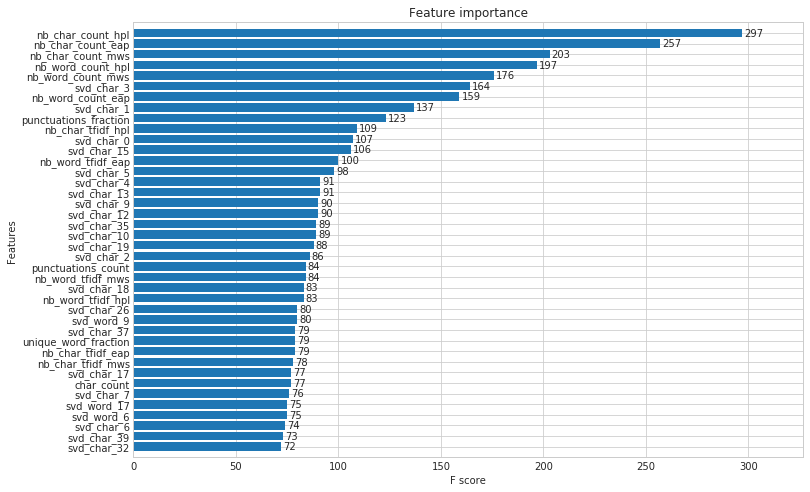

In [213]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:40]),
    ax=ax,
    height=0.8)
plt.show()

Confusion matrix, without normalization
[[1389   55   92]
 [  99 1019   50]
 [ 110   59 1043]]


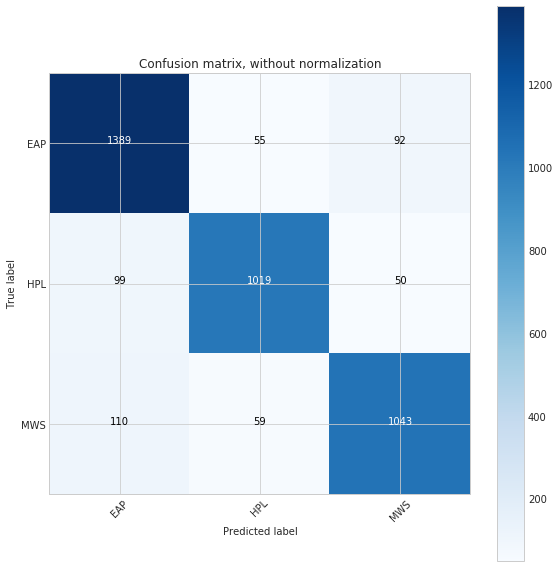

In [214]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

In [170]:
#train_2 = train[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
#train_t = np.concatenate((pred_train, np.array(train_2)), axis=1)
#
#test_2 = test[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
#test_t = np.concatenate((pred_full_test, np.array(test_2)), axis=1)

## train_test_split method

In [215]:
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(
    x_train_t, y_train, test_size=0.2, random_state=2017)
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dval = xgb.DMatrix(xval, label=yval)
dtest = xgb.DMatrix(x_test_t)
watchlist = [(dtrain, 'train'), (dval, 'valid')]

model_2 = xgb.train(
    xgb_param,
    dtrain,
    2000,
    watchlist,
    early_stopping_rounds=50,
    maximize=False,
    verbose_eval=40)

[0]	train-mlogloss:1.00106	valid-mlogloss:1.00072
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.339655	valid-mlogloss:0.351516
[80]	train-mlogloss:0.294155	valid-mlogloss:0.323697
[120]	train-mlogloss:0.267203	valid-mlogloss:0.31347
[160]	train-mlogloss:0.245807	valid-mlogloss:0.30786
[200]	train-mlogloss:0.229093	valid-mlogloss:0.303717
[240]	train-mlogloss:0.214979	valid-mlogloss:0.302174
[280]	train-mlogloss:0.201776	valid-mlogloss:0.30061
[320]	train-mlogloss:0.189236	valid-mlogloss:0.299125
[360]	train-mlogloss:0.17797	valid-mlogloss:0.29821
[400]	train-mlogloss:0.167358	valid-mlogloss:0.297411
[440]	train-mlogloss:0.157847	valid-mlogloss:0.29698
[480]	train-mlogloss:0.148862	valid-mlogloss:0.296762
[520]	train-mlogloss:0.140064	valid-mlogloss:0.297135
Stopping. Best iteration:
[490]	train-mlogloss:0.146645	valid-mlogloss:0.296664



In [217]:
pred_y_test = model_2.predict(dtest, ntree_limit=model_2.best_ntree_limit)

out_df = pd.DataFrame(pred_y_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171128-04.csv", index=False)

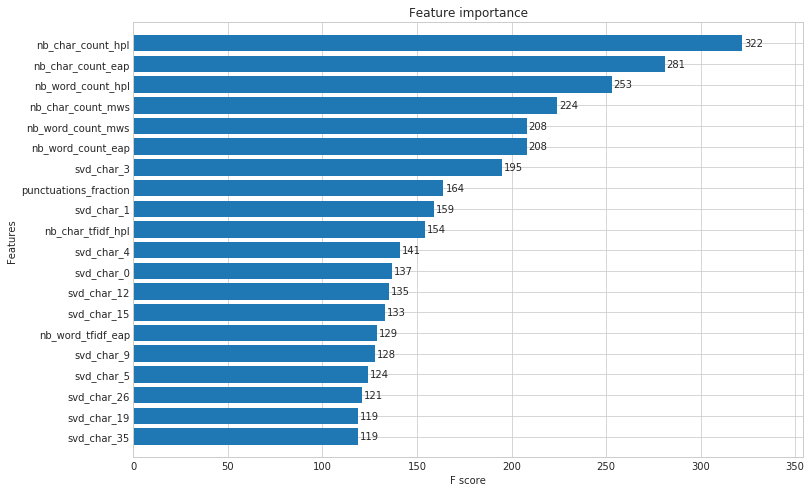

In [216]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model_2.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:20]),
    ax=ax,
    height=0.8)
plt.show()